# MicroHapulator: Interactive Demo

<small>Daniel Standage, 2022-04-25</small>

**MicroHapulator** is an application for empirical haplotype calling, analysis, and basic forensic interpretation of microhaplotypes with NGS data.
This notebook is designed to introduce MicroHapulator to new users and demonstrate its features.
The software is normally run by entering commands in a UNIX shell terminal window (available on Linux, MacOS, or the Windows Subsystem for Linux).

<img src="https://www.siliconrepublic.com/wp-content/uploads/2014/12/201503/unix-jurassic-park-718x523.jpeg" alt="It's a UNIX system. I know this" width="350" />

For convenience, however, this notebook provides an interactive environment that interleaves narrative text, shell commands that the reader can execute and re-execute, the output of those commands, and additional explanatory commentary.
To execute a block of code in the notebook, select the corresponding notebook cell and then click the `[> Run]` button at the top of the page (or as a keyboard shortcut, simultaneously press `[shift]` and `[enter]`).
As you execute each code block, the notebook will display output from the corresponding command(s).

## Getting started

This demo assumes the reader is familiar with basic terminology and concepts related to biology, genomes, and NGS sequencing.
A [primer on forensic DNA typing](https://microhapulator.readthedocs.io/en/latest/primer.html) is available for any reader unfamiliar with the topic.
A brief description of MicroHapulator's [core haplotype calling procedure](https://microhapulator.readthedocs.io/en/latest/typing.html) is also provided.
These readings are recommended before beginning this demo.

Finally, before we dive in, we need to define a function we'll use to display images in this interactive notebook.
Be sure to execute this cell before proceeding with the rest of the demo.

In [1]:
display ()
{
    TMPFILE=$(mktemp ${TMPDIR-/tmp}/bash_kernel.XXXXXXXXXX);
    cat > $TMPFILE;
    echo "bash_kernel: saved image data to: $TMPFILE" 1>&2
}

## Setup

Two mock scenarios are presented in this demo.
In both scenarios, a number of reference and evidentiary samples have been sequenced on an Illumina MiSeq with a panel targeting 23 microhaplotype markers.
The identifiers for these markers are shown below.

In [2]:
cat panel.txt

mh01USC-1pD
mh02USC-2pC
mh03USC-3qC
mh04USC-4pA
mh05USC-5pA
mh06USC-6pB
mh07USC-7pB
mh08USC-8pA
mh09USC-9pA
mh0XUSC-XqH
mh10USC-10qC
mh11USC-11pB
mh12USC-12qB
mh13USC-13qA
mh14USC-14qA
mh15USC-15qA
mh16USC-16qB
mh17USC-17pA
mh18USC-18qC
mh19USC-19qB
mh20USC-20qB
mh21USC-21qA
mh22USC-22qB


Following the instructions in the [MicroHapulator configuration manual](https://microhapulator.readthedocs.io/en/latest/config.html), configuration files were prepared previously with marker reference sequences, microhaplotype SNP definitions, and haplotype frequencies for the population of interest.
These files are listed as follows.
(The full contents of these files are available [here](https://github.com/bioforensics/MicroHapulator/tree/main/binder).)

In [3]:
ls -1 refr-seqs.fasta marker-defn.tsv frequencies.tsv

frequencies.tsv
marker-defn.tsv
refr-seqs.fasta


One of the initial steps in data analysis is mapping the NGS reads to the marker reference sequences.
This mapping procedure requires the construction of a search index for the reference sequences.
The indexing task only needs to be performed once for any given reference sequence file.

In [4]:
bwa index refr-seqs.fasta

[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index refr-seqs.fasta
[main] Real time: 0.011 sec; CPU: 0.014 sec


And then of course, we need to download the NGS reads for our mock scenarios.

In [5]:
curl -sL https://osf.io/2m3bq/download > EVD1-reads-R1.fastq.gz
curl -sL https://osf.io/swbma/download > EVD1-reads-R2.fastq.gz
curl -sL https://osf.io/vr2dn/download > EVD2-reads-R1.fastq.gz
curl -sL https://osf.io/93s8v/download > EVD2-reads-R2.fastq.gz
curl -sL https://osf.io/ytmqs/download > EVD3-reads-R1.fastq.gz
curl -sL https://osf.io/uyghd/download > EVD3-reads-R2.fastq.gz
curl -sL https://osf.io/v87zw/download > REF1-reads-R1.fastq.gz
curl -sL https://osf.io/akpvr/download > REF1-reads-R2.fastq.gz
curl -sL https://osf.io/fgqsu/download > REF2-reads-R1.fastq.gz
curl -sL https://osf.io/4kbc6/download > REF2-reads-R2.fastq.gz
curl -sL https://osf.io/fptma/download > REF3-reads-R1.fastq.gz
curl -sL https://osf.io/hyagb/download > REF3-reads-R2.fastq.gz
curl -sL https://osf.io/axfcw/download > REF4-reads-R1.fastq.gz
curl -sL https://osf.io/jgesz/download > REF4-reads-R2.fastq.gz

## Data Preprocessing and Haplotype Calling

Before diving in to our mock scenarios, let us first demonstrate how to compute a typing result.
The paired-end reads generated for each sample by the Illumina MiSeq instrument are stored in paired files, as shown below for the `EVD1` sample.

In [6]:
ls -1 EVD1-reads-R*.fastq.gz

EVD1-reads-R1.fastq.gz
EVD1-reads-R2.fastq.gz


Because of the size of the target amplicons and the length of each sequenced fragment, we expect most read pairs to have a substantial amount of overlap.
Rather than aligning and probing the paired fragments separately, we will first attempt to merge each read pair into a single sequence.
For this we use the FLASH program.

In [7]:
flash EVD1-reads-R1.fastq.gz EVD1-reads-R2.fastq.gz --allow-outies -m 100 -M 325 -o EVD1

[FLASH] Starting FLASH v1.2.11
[FLASH] Fast Length Adjustment of SHort reads
[FLASH]  
[FLASH] Input files:
[FLASH]     EVD1-reads-R1.fastq.gz
[FLASH]     EVD1-reads-R2.fastq.gz
[FLASH]  
[FLASH] Output files:
[FLASH]     ./EVD1.extendedFrags.fastq
[FLASH]     ./EVD1.notCombined_1.fastq
[FLASH]     ./EVD1.notCombined_2.fastq
[FLASH]     ./EVD1.hist
[FLASH]     ./EVD1.histogram
[FLASH]  
[FLASH] Parameters:
[FLASH]     Min overlap:           100
[FLASH]     Max overlap:           325
[FLASH]     Max mismatch density:  0.250000
[FLASH]     Allow "outie" pairs:   true
[FLASH]     Cap mismatch quals:    false
[FLASH]     Combiner threads:      8
[FLASH]     Input format:          FASTQ, phred_offset=33
[FLASH]     Output format:         FASTQ, phred_offset=33
[FLASH]  
[FLASH] Starting reader and writer threads
[FLASH] Starting 8 combiner threads
[FLASH] Processed 2500 read pairs
[FLASH]  
[FLASH] Read combination statistics:
[FLASH]     Total pairs:      2500
[FLASH]     Combined pairs:  

As noted in the FLASH output, we now have merged reads stored in the file `EVD1.extendedFrags.fastq`.
The next step in our workflow is to map the reads to the target amplicon sequences in `refr-seqs.fasta`.
In this notebook we use the `bwa mem` algorithm, but other algorithms such as `bowtie2` would also be appopriate to use here.
We also use `samtools` to convert the plain text alignments in SAM format to sorted, compressed, and indexed read alignments in BAM format.

In [8]:
bwa mem refr-seqs.fasta EVD1.extendedFrags.fastq | samtools view -b | samtools sort -o EVD1-reads.bam
samtools index EVD1-reads.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 2472 sequences (765992 bp)...
[M::mem_process_seqs] Processed 2472 reads in 0.233 CPU sec, 0.234 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem refr-seqs.fasta EVD1.extendedFrags.fastq
[main] Real time: 0.258 sec; CPU: 0.246 sec


With the aligned reads stored in `EVD1-reads.bam`, we can now use `mhpl8r type` to compute the typing result for this sample.
In addition to the BAM file containing read alignments, we also need to specify the configuration file containing marker definitions for the 23-plex panel.

Due to sequencing errors, some of the haplotypes observed in a typing result will be technical artifacts.
While computing a typing result, the `mhpl8r filter` command can apply naïve static and/or dynamic filters to distinguish true and false haplotypes and determine the sample's genotype.
We call the filtered typing result a *genotype call*.

We'll store the typing results and genotype calls in `EVD1-result.json` and then peek at the first several lines of this file.

In [9]:
mhpl8r type marker-defn.tsv EVD1-reads.bam --out EVD1-result-raw.json
mhpl8r filter EVD1-result-raw.json --dynamic 0.1 --out EVD1-result.json
cat EVD1-result.json | head -n 38

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
[MicroHapulator::type] discarded 12 reads with gaps or missing data at positions of interest
[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "markers": {
        "mh01USC-1pD": {
            "genotype": [
                {
                    "haplotype": "C,C,A"
                },
                {
                    "haplotype": "C,C,C"
                }
            ],
            "max_coverage": 109,
            "mean_coverage": 103.8,
            "min_coverage": 4,
            "num_discarded_reads": 0,
            "typing_result": {
                "C,C,A": 55,
                "C,C,C": 54
            }
        },
        "mh02USC-2pC": {
            "genotype": [
                {
                    "haplotype": "A,C,G,T"
                },
                {
                    "haplotype": "G,C,G,T"
                }
            ],
            "max_coverage": 106,
            "mean_coverage": 101.2,
            

The data is stored in JavaScript Object Notation (JSON), and includes for each marker a handful of coverage statistics, the quantitative typing result, and the genotype call.
Here we see the first two entries in the file, corresponding to the markers `mh01USC-1pD` and `mh02USC-2pC` which appear to be heterozygous for this sample.

As a final sanity check, examining the *interlocus balance* and *heterozygote balance* of each sample can reveal potential issues with the sequencing run.
Interlocus balance looks at whether there are any markers with a disproportionately high or low number of aligned reads.
This variation could be due to any combination of factors, such as primer kinetics, off-target amplification, or stochastic effects in sequencing.
With the application of appropriate thresholds, interlocus imbalance shouldn't cause serious problems with forensic  interpretation of a sample except in cases of extreme imbalance or the presence of DNA contributor(s) at very low levels in a sample.
When assessing interlocus balance, MicroHapulator peforms a chi-square goodness-of-fit test assuming uniform read coverage across markers.
The reported chi-square statistic measures the extent of imbalance, and can be compared among samples sequenced using the same panel: the minimum value of 0 represents perfectly uniform coverage, while the maximum value of D occurs when all reads map to a single marker (D represents the degrees of freedom, or the number of markers minus 1).

We assess interlocus balance with the `mhpl8r locbalance` command.

> The `--dpi` and `--figsize` arguments produce a figure convenient for display in this notebook.
> Without these optional arguments, the command produces a large high-resolution graphic by default.

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
Extent of imbalance (chi-square statistic): 0.0001


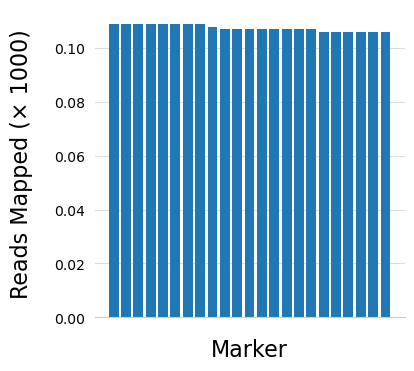

In [10]:
mhpl8r locbalance EVD1-result.json --quiet --figure EVD1-locbalance.png --dpi 100 --figsize 4 4
display < EVD1-locbalance.png

Heterozygote balance looks only at markers with two alleles, and compares the relative abundance of the major and minor alleles.
Large differences in abundance between major and minor alleles can be a source of allelic drop-out, and should be accounted for in interpretation.
This could also signify the possible presence of a second DNA contributor present at low levels in the sample.
When assessing heterozygote balance, MicroHapulator performs a paired t-test and reports the t-statistic as a measure of heterozygote imbalance.

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
Extent of imbalance (t-statistic): 6.1936


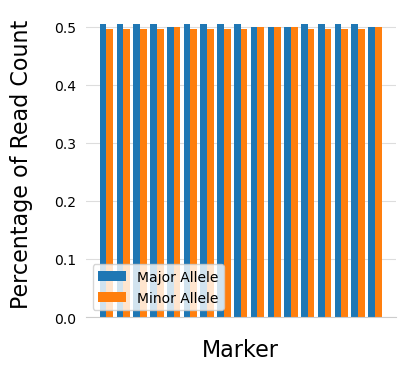

In [11]:
mhpl8r hetbalance EVD1-result.json --figure EVD1-hetbalance.png --dpi 100 --figsize 4 4
display < EVD1-hetbalance.png

Conveniently, there are no concerns for this simulated mock data.
We would expect to see more variation in real data coming off an NGS sequencer.
But observing no significant imbalance, we can proceed with our analysis and interpretation.

## Scenario 1

In our first scenario, two evidentiary samples have been collected in the course of a forensic investigation.
The case worker has leveled these samples **EVD1** and **EVD2** and suspects that both have only a single DNA contributor.
We also have a reference sample labeled **REF1** collected from a person of interest in the investigation.
All three samples were assayed with our 23-plex NGS panel, and the reads were stored in the pairs of files: `EVD1-reads-R*.fastq.gz`, `EVD2-reads-R*.fastq.gz`, and `REF1-reads-R*.fastq.gz`.

In [12]:
ls -1 EVD1-reads-R*.fastq.gz EVD2-reads-R*.fastq.gz REF1-reads-R*.fastq.gz

EVD1-reads-R1.fastq.gz
EVD1-reads-R2.fastq.gz
EVD2-reads-R1.fastq.gz
EVD2-reads-R2.fastq.gz
REF1-reads-R1.fastq.gz
REF1-reads-R2.fastq.gz


We have already shown how to merge and align the NGS reads and call haplotypes for a sample with **EVD1**.
Let us repeat the process for **EVD2** and **REF1**.

In [13]:
flash EVD2-reads-R1.fastq.gz EVD2-reads-R2.fastq.gz --allow-outies -m 100 -M 325 -o EVD2
bwa mem refr-seqs.fasta EVD2.extendedFrags.fastq | samtools view -b | samtools sort -o EVD2-reads.bam
samtools index EVD2-reads.bam
mhpl8r type marker-defn.tsv EVD2-reads.bam --out EVD2-result-raw.json
mhpl8r filter EVD2-result-raw.json --dynamic 0.1 --out EVD2-result.json

flash REF1-reads-R1.fastq.gz REF1-reads-R2.fastq.gz --allow-outies -m 100 -M 325 -o REF1
bwa mem refr-seqs.fasta REF1.extendedFrags.fastq | samtools view -b | samtools sort -o REF1-reads.bam
samtools index REF1-reads.bam
mhpl8r type marker-defn.tsv REF1-reads.bam --out REF1-result-raw.json
mhpl8r filter REF1-result-raw.json --dynamic 0.1 --out REF1-result.json

[FLASH] Starting FLASH v1.2.11
[FLASH] Fast Length Adjustment of SHort reads
[FLASH]  
[FLASH] Input files:
[FLASH]     EVD2-reads-R1.fastq.gz
[FLASH]     EVD2-reads-R2.fastq.gz
[FLASH]  
[FLASH] Output files:
[FLASH]     ./EVD2.extendedFrags.fastq
[FLASH]     ./EVD2.notCombined_1.fastq
[FLASH]     ./EVD2.notCombined_2.fastq
[FLASH]     ./EVD2.hist
[FLASH]     ./EVD2.histogram
[FLASH]  
[FLASH] Parameters:
[FLASH]     Min overlap:           100
[FLASH]     Max overlap:           325
[FLASH]     Max mismatch density:  0.250000
[FLASH]     Allow "outie" pairs:   true
[FLASH]     Cap mismatch quals:    false
[FLASH]     Combiner threads:      8
[FLASH]     Input format:          FASTQ, phred_offset=33
[FLASH]     Output format:         FASTQ, phred_offset=33
[FLASH]  
[FLASH] Starting reader and writer threads
[FLASH] Starting 8 combiner threads
[FLASH] Processed 2500 read pairs
[FLASH]  
[FLASH] Read combination statistics:
[FLASH]     Total pairs:      2500
[FLASH]     Combined pairs:  

> Normally we would examine interlocus balance or heterozygote balance before proceeding with forensic interpretation, but we'll skip this step since we're working with simulated mock data.

Forensic interpretation refers to the process of determining the conclusions, if any, that can be responsibly drawn by comparing two or more DNA profiles.
How confident can one be that two single-source profiles came from the same individual?
How confident can one be that one single-source profile is a contributor to a second mixture profile?
A variety of approaches exist for addressing these types of questions, some very simple and some very complex.
MicroHapulator implements a handful of tools for simple forensic interpretation tasks.
It also supports the export of typing results to a format that can be used by state-of-the-art probabilistic genotyping (probgen) programs.
Probgen is beyond the scope of this tutorial, but we will demonstrate the basic interpretation capabilities provided by MicroHapulator.

One question often encountered during a study or investigation is the number of DNA contributors in an evidentiary sample (or sometimes even a sample collected from a person of interest).
A single-source profile will have at most two distinct alleles at any given marker, one from each parental haplotype.
However, it's likewise possible that profile with two contributors will *also* have no more than two distinct alleles, even if the contributing genotypes are different (e.g. contributor A may be homozygous for one allele and contributor B homozygous for another allele).
But chances are that two or more DNA contributors will result in three or more alleles for at least a *small* number of markers.
We can use this observation to estimate the minimum number of contributors for a profile.

The `mhpl8r contrib` command implements a procedure to scan a typing result to determine the maximum number of alleles $N_{\text{al}}$ present at any single locus. From this, it can calculate the minimum number of DNA contributors $C_{\text{min}}$ as follows.

$$
C_{\text{min}} = \left\lceil\frac{N_{\text{al}}}{2}\right\rceil
$$

We begin by applying this to the three profiles in our mock scenario.

In [14]:
mhpl8r contrib EVD1-result.json
mhpl8r contrib EVD2-result.json
mhpl8r contrib REF1-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "min_num_contrib": 1,
    "num_loci_max_alleles": 23,
    "perc_loci_max_alleles": 1.0
}[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "min_num_contrib": 1,
    "num_loci_max_alleles": 23,
    "perc_loci_max_alleles": 1.0
}[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "min_num_contrib": 1,
    "num_loci_max_alleles": 23,
    "perc_loci_max_alleles": 1.0
}

In all three profiles, none of the 23 markers has evidence for more than a single contributor.
It would thus be reasonable to pursue additional interpretation under the assumption that these are all single-source samples.

Depending on the details of the investigation, it might be necessary to investigate whether the two evidentiary came from the same individual, or whether one of the the evidentiary samples matches a reference sample collected from a person of interest.
The most basic approach to addressing this question is to examine a pair of profiles and determine, marker by marker, whether there are any differences between the genotypes.
Given two MicroHapulator typing results, the `mhpl8r diff` command will print any alleles that are present in one profile but not the other.

In [15]:
mhpl8r diff EVD1-result.json REF1-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty


In [16]:
mhpl8r diff EVD1-result.json EVD2-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
mh01USC-1pD
>>> C,C,C
mh02USC-2pC
>>> A,C,G,T
<<< G,C,T,T
mh03USC-3qC
>>> A,C,C,A,G
<<< G,T,C,G,G
mh04USC-4pA
<<< G,T,A,A
mh06USC-6pB
>>> T,A,A
<<< C,G,A
mh07USC-7pB
>>> A,G,G,C
<<< T,A,A,C
mh08USC-8pA
>>> A,G,T,A
<<< A,G,T,G
mh09USC-9pA
>>> G,T,C,A,C
>>> G,T,C,G,C
<<< A,T,C,A,A
<<< A,T,T,G,C
mh0XUSC-XqH
>>> T,C,T
<<< G,T,T
<<< T,C,C
mh10USC-10qC
<<< G,C,A
mh11USC-11pB
>>> C,A,T,G
<<< C,G,C,G
mh12USC-12qB
>>> A,A,A,T
<<< G,A,A,C
mh13USC-13qA
>>> A,T,A,A
<<< A,C,A,G
mh14USC-14qA
>>> G,C,G
<<< T,C,G
mh15USC-15qA
>>> A,C,A,A
>>> A,T,A,G
<<< A,T,A,A
<<< G,T,A,A
mh16USC-16qB
>>> G,A,T
<<< A,A,T
mh17USC-17pA
>>> T,C,A
<<< T,C,C
mh18USC-18qC
>>> G,A,A,G
mh19USC-19qB
>>> A,G,A
>>> G,G,G
<<< G,C,A
<<< G,G,A
mh20USC-20qB
<<< T,C,G,C
mh21USC-21qA
>>> G,T,G,G
mh22USC-22qB
>>> G,G,C,G,T


The first result shows that there are no differences between the **EVD1** profile and the **REF1** profile, so there is already strong evidence that these were derived from the same individual.

The second result shows numerous differences between **EVD1** and **EVD2**.
It's not uncommon to see minor discrepancies between different samples originating from the same individual—variability in laboratory processing or sample degradation could explain some of these differences.
But if this were the case we would not typically expect to see discordant alleles at almost every marker.
The much more likely explanation in this case is that **EVD1** and **EVD2** come from different individuals.

But beyond a basic check for their presence or absence, an exhaustive listing of discordant alleles isn't very helpful (except perhaps for troubleshooting purposes).
What we *really* want is a quantitative measure of our confidence in a match between two profiles.
We derive this measure by assessing the likelihood of two propositions—two competing hypotheses or explanations for the data.
Depending on the details of the investigation, we might formulate the likelihood ratio (LR) test as something like the following.

- $H_p$: **REF1** and **EVD1** originated from the same individual
- $H_d$: **REF1** and **EVD1** originated from two unrelated individuals in the population

We then compute the ratio of the two hypotheses' probabilities as $LR = \frac{P(H_p)}{P(H_d)}$.
Large LR values are strong evidence in favor of $H_p$, small LR values support $H_d$, and LR values close to 1.0 are inconclusive.

The probability $P(H_p) = \epsilon^R$, where $\epsilon$ is a per-marker rate of genotyping error (default: 0.001) and $R$ is the number of markers with discordant alleles between samples.
The probability $P(H_d)$ is the random match probability (RMP) of the profile, which is essentially the product of the observed haplotype frequencies in the population.
Note that in cases of a perfect profile match, $P(H_p) = 1$ and the LR is then simply the reciprocal of the RMP.

We can use `mhpl8r prob` both to compute the RMP for the evidence and to perform the LR test as formulated above.

In [17]:
mhpl8r prob frequencies.tsv EVD1-result.json
mhpl8r prob frequencies.tsv EVD1-result.json REF1-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "random_match_probability": "1.394E-23"
}[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "likelihood_ratio": "7.176E+22"
}

The result is a very large LR of $7.18 \times 10^{22}$, lending strong support to $H_p$ over $H_d$, consistent with our earlier observations.

Now let's consider what would happen if, disregarding our earlier observations, we had formulated the LR test as follows.

- $H_p$: **REF2** and **EVD1** originated from the same individual
- $H_d$: **REF2** and **EVD1** originated from two unrelated individuals in the population

In [18]:
mhpl8r prob frequencies.tsv EVD2-result.json
mhpl8r prob frequencies.tsv EVD2-result.json REF1-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "random_match_probability": "1.066E-23"
}[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "likelihood_ratio": "9.384E-59"
}

Here we see a very different result.
The RMP for **EVD2** is of similar magnitude to that of **EVD1**, but the LR test statistic is very small.
A tremendous amount of error would be required if **EVD2** and **REF1** were from the same individual—much more likely is that these samples originated from two unrelated individuals.

## Scenario 2

In this scenario, the case worker has collected an evidentiary sample (**EVD3**) in the course of a forensic investigation, and there is some suspicion that this sample has multiple DNA contributors.
We have also collected reference samples from three persons of interest in the investigation, labeled **REF2**, **REF3**, and **REF4**.
As in the previous scenario, all four samples have been sequenced with our 23-microhap NGS panel.
Reads are available in the following files.

In [19]:
ls -1 EVD3-reads-R*.fastq.gz REF2-reads-R*.fastq.gz REF3-reads-R*.fastq.gz REF4-reads-R*.fastq.gz

EVD3-reads-R1.fastq.gz
EVD3-reads-R2.fastq.gz
REF2-reads-R1.fastq.gz
REF2-reads-R2.fastq.gz
REF3-reads-R1.fastq.gz
REF3-reads-R2.fastq.gz
REF4-reads-R1.fastq.gz
REF4-reads-R2.fastq.gz


As before, we will merge the read pairs, align the merged reads to the reference sequences, and compute a typing result for each sample.

In [20]:
flash EVD3-reads-R1.fastq.gz EVD3-reads-R2.fastq.gz --allow-outies -m 100 -M 325 -o EVD3 --quiet
bwa mem refr-seqs.fasta EVD3.extendedFrags.fastq | samtools view -b | samtools sort -o EVD3-reads.bam
samtools index EVD3-reads.bam
mhpl8r type marker-defn.tsv EVD3-reads.bam --out EVD3-result-raw.json
mhpl8r filter EVD3-result-raw.json --dynamic 0.1 --out EVD3-result.json

flash REF2-reads-R1.fastq.gz REF2-reads-R2.fastq.gz --allow-outies -m 100 -M 325 -o REF2 --quiet
bwa mem refr-seqs.fasta REF2.extendedFrags.fastq | samtools view -b | samtools sort -o REF2-reads.bam
samtools index REF2-reads.bam
mhpl8r type marker-defn.tsv REF2-reads.bam --out REF2-result-raw.json
mhpl8r filter REF2-result-raw.json --dynamic 0.1 --out REF2-result.json

flash REF3-reads-R1.fastq.gz REF3-reads-R2.fastq.gz --allow-outies -m 100 -M 325 -o REF3 --quiet
bwa mem refr-seqs.fasta REF3.extendedFrags.fastq | samtools view -b | samtools sort -o REF3-reads.bam
samtools index REF3-reads.bam
mhpl8r type marker-defn.tsv REF3-reads.bam --out REF3-result-raw.json
mhpl8r filter REF3-result-raw.json --dynamic 0.1 --out REF3-result.json

flash REF4-reads-R1.fastq.gz REF4-reads-R2.fastq.gz --allow-outies -m 100 -M 325 -o REF4 --quiet
bwa mem refr-seqs.fasta REF4.extendedFrags.fastq | samtools view -b | samtools sort -o REF4-reads.bam
samtools index REF4-reads.bam
mhpl8r type marker-defn.tsv REF4-reads.bam --out REF4-result-raw.json
mhpl8r filter REF4-result-raw.json --dynamic 0.1 --out REF4-result.json

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 4976 sequences (1538831 bp)...
[M::mem_process_seqs] Processed 4976 reads in 0.424 CPU sec, 0.424 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem refr-seqs.fasta EVD3.extendedFrags.fastq
[main] Real time: 0.464 sec; CPU: 0.443 sec
[MicroHapulator] running version 0.5+71.g8725f3b.dirty
[MicroHapulator::type] discarded 26 reads with gaps or missing data at positions of interest
[MicroHapulator] running version 0.5+71.g8725f3b.dirty
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 32352 sequences (10000334 bp)...
[M::process] read 16695 sequences (5162223 bp)...
[M::mem_process_seqs] Processed 32352 reads in 2.511 CPU sec, 2.499 real sec
[M::mem_process_seqs] Processed 16695 reads in 1.573 CPU sec, 1.570 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem refr-seqs.fasta REF2.extendedFrags.fastq
[main] Real time: 4.253 sec; CPU: 4.142 sec
[MicroHapulator] running version 0.5+71.g8725f3b.dirty


We now want to examine the evidentiary sample and investigate the presence of multiple DNA contributors.

In [21]:
mhpl8r contrib EVD3-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "min_num_contrib": 3,
    "num_loci_max_alleles": 2,
    "perc_loci_max_alleles": 0.087
}

In this sample, we observe two loci that provide evidence for at least three DNA contributors, i.e. five or more distinct haplotypes.
If you examine `EVD3-result.json`, there are numerous markers with three or four haplotypes, but the two markers with 5 haplotypes are strong evidence for three DNA contributors.

We can then test whether any of the reference samples is a contributor to the evidentiary mixture.
MicroHapulator implements a simple containment test to investigate this question.
In brief, the containment test examines each marker and determines whether the genotype in a profile of interest is compatible with the genotype of a mixture profile.
For example, if a reference sample **REF99** has a `A,C,T / A,T,T` genotype at a marker and an evidentiary mixture sample **EVD99** has a `A,C,G / A,C,T / A,T,T` genotype, **REF99** is compatible, e.g. a plausible contributor to **EVD99**.
On the other hand, if the **REF99** genotype at a different marker is `G,G,A,T / C,G,T,T` and the **EVD99** genotype is `G,G,A,T / G,G,T,T`, **REF99** is not a plausible contributor to **EVD99**.
In the end, the containment test reports the percentage of markers in one profile with compatible genotypes to another (mixture) profile.

We can use the `mhpl8r contrib` command to perform the containment test for **REF2**.

In [22]:
mhpl8r contain EVD3-result.json REF2-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "containment": 1.0,
    "contained_alleles": 39,
    "total_alleles": 39
}

This tells us that 100% of the haplotypes observed in **REF2** are present in **EVD3**, suggesting that **REF2** is a plausible contributor to **EVD3**.
What can we say about **REF3** and **REF4**?

In [23]:
mhpl8r contain EVD3-result.json REF3-result.json
mhpl8r contain EVD3-result.json REF4-result.json

[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "containment": 0.7297,
    "contained_alleles": 27,
    "total_alleles": 37
}[MicroHapulator] running version 0.5+71.g8725f3b.dirty
{
    "containment": 0.8649,
    "contained_alleles": 32,
    "total_alleles": 37
}

Only about 70-85% of the alleles in both of these samples are present in **EVD3**, suggesting that they are unlikely to be contributors to the sample.

As a final note, it important acknowledge several factors that can influence the the containment statistic.
It is not always possible to develop thresholds that eliminate all errors and detects all true haplotypes.
This is especially the case for low-input samples or mixtures with an imbalance between major and minor contributors.
MicroHapulator's containment test does not account for allelic drop-in (false positives) or drop-out (false negatives).
We also note that many haplotypes from non-contributors will be present in a mixture simply by chance, and there is no simple theoretical threshold we can apply to distinguish between "true" and "false" containment.
The containment test is a basic tool that provides a quick check to guide an investigation.
Probabilistic genotyping (probgen) methods, on the other hand, provide for a much more robust interpretation of forensic propositions, with models for drop-in and drop-out evaluated in a maximum likelihood framework.
Probgen is beyond the scope of this tutorial, but the use of probgen tools such as LRMix Studio or EuroForMix is recommended for definitive interpretation of DNA mixtures.
